# 1b: EXPLORATORY DATA ANALYSIS

This notebook aims to answer the following questions:

* What is the highest rated movie in 2023?
* How do we balance ratings and number of votes?
* Who was the most popular actor in 2023?
* What are the trends in user-movie preferences over the years?
* Define a metric that captures the notion of a **hit movie**; justify your metric in the context of a movie studio director looking to invest in building the next AAA title

In [1]:
import pandas as pd

# Load data
data = pd.read_csv('processed_data/data.csv', index_col=0)
data = data.dropna(subset='runtimeMinutes')
data.head()

,primaryTitle,isAdult,startYear,runtimeMinutes,genres,averageRating,numVotes,actor,actress,casting_director,cinematographer,composer,director,editor,producer,production_designer,self,writer,gross_income
tconst,,,,,,,,,,,,,,,,,,,
tt0000009,Miss Jerry,0,1894.0,45.0,Romance,5.4,211,"nm0183823,nm1309758",nm0063086,NaN,nm0085156,NaN,nm0085156,NaN,nm0085156,NaN,NaN,nm0085156,0.0
tt0000147,The Corbett-Fitzsimmons Fight,0,1897.0,100.0,"Documentary,News,Sport",5.2,512,NaN,NaN,NaN,nm0714557,NaN,nm0714557,NaN,nm0103755,NaN,"nm0179163,nm0280615,nm4082222,nm4081458,nm2256592",NaN,0.0
tt0000574,The Story of the Kelly Gang,0,1906.0,70.0,"Action,Adventure,Biography",6.0,900,"nm0846894,nm1431224,nm3002376,nm0143899,nm3001...","nm0846887,nm0170118",NaN,"nm0425854,nm0675239,nm0675260",nm2421834,nm0846879,NaN,"nm0317210,nm0425854,nm0846894,nm0846911",NaN,NaN,nm0846879,0.0
tt0000591,The Prodigal Son,0,1907.0,90.0,Drama,5.4,24,"nm0906197,nm0332182","nm1323543,nm1759558",NaN,NaN,NaN,nm0141150,NaN,NaN,NaN,NaN,nm0141150,0.0
tt0000679,The Fairylogue and Radio-Plays,0,1908.0,120.0,"Adventure,Fantasy",5.2,73,"nm0000875,nm0122665,nm0122665,nm0933446,nm0933...",NaN,NaN,NaN,nm0542903,"nm0091767,nm0877783",NaN,"nm0000875,nm0877783",NaN,NaN,"nm0000875,nm0877783",0.0


## QUESTION 1

**1a. What is the highest rated movie in 2023?**

**1b. How do we balance ratings and number of votes?**


1. **Filter the Data:** Filter out movies released in 2023 and with valid ratings.

2. **Balance Ratings and Votes:** Consider both the average rating and the number of votes to avoid high ratings from movies with very few votes. A common method to balance this is using the Bayesian Average:

\begin{equation}
\bar{x}=\displaystyle\frac{Cm+\sum^{n}_{i=1}x_i}{C+n}
\end{equation}

where $\displaystyle\sum^{n}_{i=1}x_i$
is approximated as $n$ $\times$ averageRating, given that $x_i$ for all $i$ would be the same in this simplification (since each movie has one average rating). $C$ is the mean rating across all movies, and $m$ is chosen as the 50th percentile of votes to ensure only movies with a significant number of votes influence the top rated selection.

In [8]:
movies_2023 = data.loc[data['startYear']==2023].copy()

PERCENTILE =  0.75

# Define a function to calculate the Bayesian average
def bayesian_average(x, m, C):
    n = x['numVotes']
    sum_ratings = n * x['averageRating']
    return (C * m + sum_ratings) / (m + n)

# Calculate the mean vote across all movies and the minimum votes required to be considered
C = movies_2023['averageRating'].mean()
m = movies_2023['numVotes'].quantile(PERCENTILE)

# Apply the Bayesian average formula
movies_2023['bayesian_average'] = movies_2023.apply(bayesian_average,
                                                    args=(m, C), axis=1)

movies_2023_top = movies_2023.loc[movies_2023['numVotes']>=m]

# Find the highest rated movie
highest_rated_movie_avg = movies_2023_top.loc[movies_2023_top['averageRating']\
                                          .idxmax()].copy()

print("Highest rated movie in 2023 (averageRating) is:")
print(highest_rated_movie_avg)

# Find the highest rated movie
highest_rated_movie_bayes = movies_2023_top.loc[movies_2023_top['bayesian_average']\
                                          .idxmax()].copy()

print("Highest rated movie in 2023 (Bayesian Average) is:")
print(highest_rated_movie_bayes)

Highest rated movie in 2023 (averageRating) is:
primaryTitle                                       Nimmellara Aashirvada
isAdult                                                                0
startYear                                                         2023.0
runtimeMinutes                                                     124.0
genres                                                      Comedy,Drama
averageRating                                                        9.6
numVotes                                                             611
actor                  nm12782656,nm5794293,nm9934189,nm5741813,nm121...
actress                                  nm9634067,nm15077021,nm10293255
casting_director                                                     NaN
cinematographer                                                nm8935492
composer                                                      nm10244911
director                                                      nm15059355
edi

## QUESTION 2

**Who was the most popular actor in 2023?**

* Count the number of appearances of each actor/actress in titles from 2023 and use the Bayesian average to enhance accuracy.

In [3]:
movies2023_quality = movies_2023.loc[movies_2023['bayesian_average']>=movies_2023['bayesian_average'].quantile(PERCENTILE)]

movies2023_2 = movies2023_quality[['primaryTitle','actor','actress']].copy().fillna('')
movies2023_2['actor_actress'] = movies2023_2['actor'] + ',' + movies2023_2['actress']
movies2023_2 = movies2023_2.drop(['actor','actress'], axis=1)
movies2023_2

,primaryTitle,actor_actress
tconst,,
tt0070596,Socialist Realism,"nm0031652,nm0250185,nm15107981,nm0539221,nm056..."
tt0439572,The Flash,"nm3009232,nm3009232,nm0000474,nm0000474,nm0788..."
tt10037498,Power Alley,"nm14762756,nm2363124,nm14885343,nm4498129,nm74..."
tt10098448,Jesus Revolution,"nm1525807,nm0745751,nm0001288,nm0084153,nm7669..."
tt10133702,Pelikan Blue,"nm6086017,nm0862286,nm0190817,nm7039943,nm1097..."
...,...,...
tt9718974,Beyond the Beach: The Hell and the Hope,","
tt9824856,Avalakki Pavalakki,"nm15285013,"
tt9873892,They Cloned Tyrone,"nm3915784,nm0004937,nm0000662,nm0004979,nm4544..."


In [4]:
from collections import Counter

actorlist = ','.join(movies2023_2['actor_actress']).split(',')
count_actor = Counter(actorlist)

# Delete a key from the Counter
del count_actor['']

count_actor = pd.Series(count_actor).sort_values(ascending=False)
topnconst = count_actor.head(1).index
count_actor

nm1428724     9
nm0043199     8
nm4148153     7
nm8547541     7
nm9109380     6
             ..
nm15313017    1
nm0163223     1
nm0684001     1
nm0284482     1
nm8463983     1
Length: 12594, dtype: int64

## Look up in the list of names

In [5]:
name_basics = pd.read_csv('./raw_data/name.basics.tsv.gz',
                          sep='\t', compression='gzip',index_col='nconst')
name_basics.head()

,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
nconst,,,,,
nm0000001,Fred Astaire,1899,1987,"actor,miscellaneous,producer","tt0072308,tt0050419,tt0053137,tt0027125"
nm0000002,Lauren Bacall,1924,2014,"actress,soundtrack,archive_footage","tt0037382,tt0075213,tt0117057,tt0038355"
nm0000003,Brigitte Bardot,1934,\N,"actress,music_department,producer","tt0057345,tt0049189,tt0056404,tt0054452"
nm0000004,John Belushi,1949,1982,"actor,writer,music_department","tt0072562,tt0077975,tt0080455,tt0078723"
nm0000005,Ingmar Bergman,1918,2007,"writer,director,actor","tt0050986,tt0083922,tt0050976,tt0069467"


In [6]:
name_basics.loc[topnconst]

,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
nm1428724,Indrans,1956,\N,"actor,costume_designer,music_department","tt10534500,tt3951566,tt8066304,tt9006564"


Based on this approach, the most popular actor is Indrans.

## QUESTION 3

**What are the trends in user-movie preferences over the years?**

To analyze trends in user-movie preferences over the years, factors such as the average ratings of movies, the number of ratings per movie, and how these change annually need to be considered.

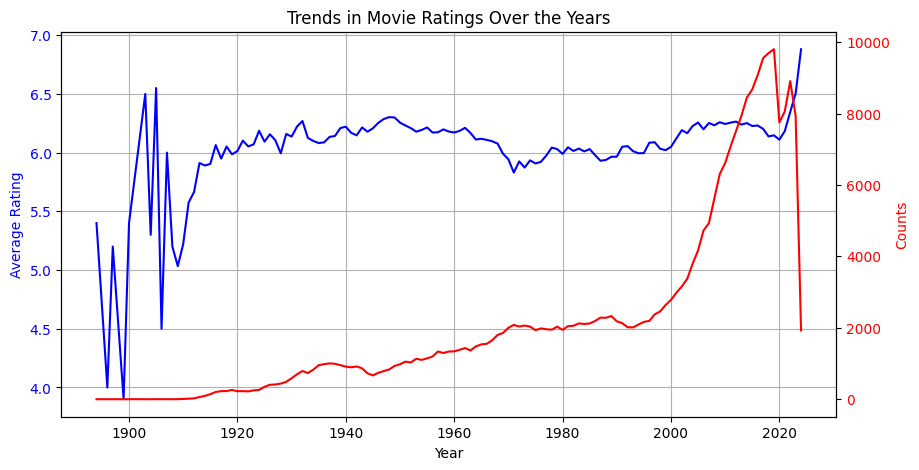

In [7]:
import matplotlib.pyplot as plt


ratings_years = data[['averageRating','startYear']].dropna()
ratings_years['startYear'] = ratings_years['startYear'].astype(int)

# Group by year and calculate the average rating
average_ratings_per_year = ratings_years.groupby('startYear')\
                           ['averageRating'].mean().reset_index()

# Analyze the number of ratings per year to see popularity trends
ratings_count_per_year = ratings_years.groupby('startYear').size()\
                         .reset_index(name='count')

# Merge the average ratings with counts
trends = pd.merge(average_ratings_per_year, ratings_count_per_year,
                  on='startYear').sort_values('startYear')

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 5))

# Second axis for counts of ratings
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# First axis for average ratings
ax1.set_xlabel('Year')
ax1.set_ylabel('Average Rating', color='b')
ax1.plot(trends['startYear'], trends['averageRating'], color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2.set_ylabel('Counts', color='r')  # we already handled the x-label with ax1
ax2.plot(trends['startYear'], trends['count'], color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Title and grid
plt.title('Trends in Movie Ratings Over the Years')
ax1.grid(True)

# Show the plot
plt.show()

## Comments

1. **Early Data Volatility:** Both the average ratings and counts of ratings show significant fluctuations in the early 1900s. This could be attributed to the relatively fewer number of movies and ratings, causing each individual rating to have a disproportionate impact on the overall average.

2. **Stabilization of Average Ratings:** By around the 1940s onward, the average movie ratings appear to stabilize predominantly between approximately 5.5 and 6.5. This suggests a more consistent quality of movies, or possibly stabilization in audience rating behavior.

3. **Increasing Trend in Rating Counts:** Starting from around the mid-20th century, there is a clear upward trend in the counts of ratings, which becomes quite pronounced post-1980. This could reflect the growth in the movie industry, increased accessibility to rating platforms, and a growing population of movie-goers.

4. **Recent Years:** There is a noticeable spike in both average ratings and rating counts around 2020. This spike in average ratings could be due to selective viewership, where perhaps more devoted or enthusiastic viewers are more likely to rate movies. The spike in rating counts could also suggest increased viewership during the COVID-19 pandemic when many people turned to movies for entertainment during lockdowns.

5. **Post-2020 Drop:** The sharp drop in rating counts post-2020 might indicate a delay in data collection, a decrease in movie releases, or changes in how ratings are recorded or reported.

## QUESTION 3

**Define a metric that captures the notion of a ‘hit movie’; justify your
metric in the context of a movie studio director looking to invest in
building the next AAA title**

A **COMPOSITE SCORE** will be computed in the next notebook which takes into account the following. It hopes to reflect the overall profitablity of a movie.

This outlines the method in defining a metric that captures the notion of a “hit movie”. In the merged dataset. The following features was used in producing a single metric:

- **NUMBER OF VOTES.** Servers as an indicator of the title's popularity and viewer engagement.

- **GROSS INCOME**. A key indicator of the title's financial success and market appeal.

- **AVERAGE RATINGS.** Reflects the overall viewer reception and satisfaction. Higher ratings often indicate a more favorable response from the audience.
